# hh.kz CV analysis

I wanted to know two things:

1. If women really asks for smaller salary then men
2. Who are people on Data Science market of KZ

So I parsed open resumes from hh.kz for data people, finance and frontend.

## Libraries

In [1]:
options(repr.plot.width = 5, repr.plot.height = 3, scipen = 999, warn = -1)

In [2]:
library(xml2)
library(rvest)
library(httr)
library(stringr)
library(RCurl)

Loading required package: bitops


## Functions & Settings

In [3]:
getProxy  <- function(url) {
    
    ### Magical function to get proxy settings
    
}

In [4]:
read_with_proxy <- function(site_url) {
    
    ### Read webpage with proxy settings
    
    getURL(url = site_url, .opts = setProxyOpts(proxy = proxy)) %>% 
    read_html(url)
}    

In [5]:
cv_search_url <- function(keyword, page = '0') {
    
    ### Make search url by keyword
    ### Settings: search only in CV title, all phrase, default page number is 0
    
    paste0('https://hh.kz/search/resume?text=', keyword, '&logic=phrase&pos=position&exp_period=last_year&clusters=true&area=40&currency_code=KZT&order_by=relevance&no_magic=false&page=', page)
}

cv_search_url_salary <- function(keyword, page = '0') {
    
    ### Make search url by keyword
    ### Settings: search only in CV title, all phrase, default page number is 0, indicated salary less then 1 mln KZT
    
    paste0('https://hh.kz/search/resume?text=', keyword, '&logic=phrase&pos=position&exp_period=last_year&salary_to=1000000&clusters=true&area=40&currency_code=KZT&order_by=relevance&no_magic=false&page=', page)
}

number_of_pages <- function(webpage) {
    
    ### Count number of pages for a search by keyword
    ### 20 CVs per page
    
    number_of_cvs <- 
    webpage %>% 
    html_nodes('[data-qa = page-title]') %>% 
    html_text() %>% 
    str_extract('Найдено.+?резюме') %>% 
    str_remove_all('[^[:digit:]]') %>% 
    as.numeric
    
    cvs_per_page <- 20
    
    floor(number_of_cvs / cvs_per_page)
}

get_cv_ids <- function(webpage) {
    
    ### Get CV ids from search page
    
    webpage %>% 
    html_nodes('[itemprop = jobTitle]') %>% 
    as.character() %>% 
    str_extract_all(pattern = '/resume/.{38}') %>% 
    str_remove_all('/resume/')
}

In [6]:
get_data <- function(webpage = cv_webpage, item) {
    
    ### Parse CV data by item
    ### If item is empty returns NA
    ### else concatenate all data, i.e. all education, experience and skills 
    
    tmp <- 
    html_nodes(webpage, item) %>% 
    html_text()
    
    if (length(tmp) == 0) {
        NA
    } else {
        tmp %>% 
        unique %>% 
        paste(collapse = '_')  %>% 
        str_trim
    }
}

In [7]:
cv_parse  <- function(site_url) {
    
    ### Parse all CV data and append to cvs dataframe
    
    # read CV webpage with proxy settings
    cv_webpage <<- read_with_proxy(site_url)
    
    # parse data
    
    position  <- get_data(item = '[data-qa = resume-block-title-position]')

    sex  <- get_data(item = '[data-qa = resume-personal-gender]')

    age  <- get_data(item = '[data-qa = resume-personal-age]')

    city  <- get_data(item = '[data-qa = resume-personal-address]')

    salary  <- get_data(item = '[data-qa = resume-block-salary]')

    experience_years  <- 
    html_nodes(cv_webpage, '[data-qa = resume-block-experience]') %>% 
    get_data(item = '.resume-block__title-text') %>% 
    str_remove_all('Опыт работы |Work experience ')

    experience_companies  <-
    html_nodes(cv_webpage, '[data-qa = resume-block-experience]') %>% 
    get_data(item = '[itemprop = name]')    

    education  <- 
    html_nodes(cv_webpage, '[data-qa = resume-block-education]') %>% 
    get_data(item = '[data-qa = resume-block-education-name]')

    skills  <- 
    html_nodes(cv_webpage, '[data-qa = skills-table]') %>% 
    get_data('[data-qa = bloko-tag__text]')
    
    # append data to cvs dataframe
    
    cvs <<- rbind(cvs, data.frame(position, 
                             sex, 
                             age, 
                             city, 
                             salary, 
                             experience_years, 
                             experience_companies, 
                             education, 
                             skills, 
                             stringsAsFactors = F))
}

## Parsing

In [8]:
# Empty DF for CVs

cvs <- read.csv(text = 'position, sex, age, city, salary, experience_years, experience_companies, education,  skills', stringsAsFactors = F)

ds_keywords  <- c('аналитик+данных', 'data+analyst', 'data+scientist')

frontend_keywords <- c('верстальщик', 'frontend', 'фронтенд')

finance_keywords  <- c('финансист')

cv_url  <- 'https://hh.kz/resume/'

cv_ids <- c()

In [9]:
salary = FALSE

proxy <- getProxy()

for (keyword in ds_keywords) {
    
    ### Get CV ids for all keywords
    
    print(keyword)
    
    if (salary == TRUE) {
        
        search_url <- cv_search_url_salary(keyword)
        
    } else {
        
        search_url <- cv_search_url(keyword)
    }
    
    search_wp <- read_with_proxy(search_url)
    
    cv_ids <<- c(cv_ids, get_cv_ids(search_wp))
    
    pages <- number_of_pages(search_wp)
    
    print(paste0('Pages: ', pages + 1))
    print(paste0('Finished page: ', 1))
    
    if (pages > 0) {
        for (page in 1:pages) {
            
                if (salary == TRUE) {
                    
                    search_url <- cv_search_url_salary(keyword, page)
                
                } else {
                    
                    search_url <- cv_search_url(keyword, page)
                }
    
            search_wp <- read_with_proxy(search_url)
    
            cv_ids <<- c(cv_ids, get_cv_ids(search_wp))
            
            print(paste0('Finished page: ', page + 1))
        
        }
    }    
}

[1] "аналитик+данных"
[1] "Pages: 1"
[1] "Finished page: 1"
[1] "data+analyst"
[1] "Pages: 3"
[1] "Finished page: 1"
[1] "Finished page: 2"
[1] "Finished page: 3"
[1] "data+scientist"
[1] "Pages: 4"
[1] "Finished page: 1"
[1] "Finished page: 2"
[1] "Finished page: 3"
[1] "Finished page: 4"


In [10]:
cv_ids  <- unique(cv_ids)

cat('CVs found:', length(cv_ids), '\n\nExamples:')

cat(cv_ids[1:3])

CVs found: 120 

Examples:ab08e92c00054e94250039ed1f723865427763 908e021d0001cf335f0039ed1f546530673341 6bdc1da70006d3a40b0039ed1f57616c724e6a

In [11]:
#cvs <- read.csv(text = 'position, sex, age, city, salary, experience_years, experience_companies, education,  skills', stringsAsFactors = F)

proxy <- getProxy()

i = 1

for (id in cv_ids) {
    
    ### Parse all CVs
    
    site_url  <- paste0(cv_url, id)
    
    cv_parse(site_url)
    
    i = i + 1
}

print(paste0('Parsed ', i, ' resumes'))

In [12]:
#write.csv(cvs, 'dsml_cvs_data.csv', row.names = F)

## Data Analysis

In [13]:
library(dplyr)
library(ggplot2)
library(wordcloud2)
library(ggthemes)
library(ggthemr)
ggthemr('dust')


# Color palette for sex comparison
sex_colors_dark <- c('#C84E9E', '#4881A9')


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [14]:
k_formatter <- function(x){
    
    ### Form K numbers from thousands
    
    paste0(format(round(x/1000), big.mark = ' '), 'K')
}

prepare_df  <- function(df) { 
    
    ### Extract data in needed form: text to num, recode strings to one language, remove non KZ cities,
    ### calculate salary in KZT and total experience in num
    
    df %>% 
    filter(!city %in% c('Пермь', 'Минск', 'India', 'Moscow')) %>% 
    mutate(sex = recode(sex, 'Male' = 'Мужчина', 'Female' = 'Женщина', 'Ер' = 'Мужчина'),
          age = as.numeric(str_extract_all(age, '[0-9]+')),
          city = recode(city, 'Almaty' = 'Алматы', 'Atyrau' = 'Атырау', 'Nur-Sultan' = 'Нур-Султан', 'Shymkent' = 'Шымкент'),
          salary = str_remove_all(salary, '\\<U\\+2009\\>'), 
          salary_currency = str_sub(salary, -3),
          salary_value = as.numeric(str_remove_all(salary, '[^[:digit:]]')),
          salary_kzt = ifelse(salary_currency == 'USD', salary_value * usd_to_kzt, salary_value),
          exp_years = sub('(year|год|лет).*', '', experience_years),
          exp_years = as.numeric(str_trim(ifelse(str_detect(exp_years, 'мес|month'), NA, exp_years))),
          exp_months = as.numeric(str_trim(str_sub(str_trim(str_extract(experience_years, '.*(?=мес|month)')), -2))),
          exp_total = ifelse(is.na(exp_years), 0, exp_years) + ifelse(is.na(exp_months), 0, exp_months) / 12)
}

build_plot <- function(df = finance_mod, profession = 'финансистов') {
    
    ### Calculate indicated salary distribution for different sex
    
    # Density plot
    plot <- df %>% 
    filter(!is.na(salary_kzt)) %>% 
    ggplot(aes(x = salary_kzt, fill = sex)) +
    geom_density(alpha = .55, color = NA) +
    scale_fill_manual(values = sex_colors_dark) +
    scale_x_continuous(label = k_formatter, limits = c(0, 500000), breaks = seq(0, 500000, 50000)) +
    labs(x = '', y = '', title = '') +
    theme(legend.position = 'none',
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        panel.background = element_rect(fill = '#FFF2D9'),
        panel.grid.major.x = element_line(colour = '#FFD788', size = .25),
        panel.grid.major.y = element_blank(),
        panel.grid.minor = element_blank(),
        plot.title = element_text(face = 'bold', size = 8),
        plot.subtitle = element_text(face = 'italic'),
        text = element_text(size = 6))

    # Quantile stats
    stats  <- df %>% 
    filter(!is.na(salary_kzt)) %>% 
    group_by(sex) %>% 
    summarise(cnt = n(), q25 = quantile(salary_kzt, .25), q50 = median(salary_kzt), q75 = quantile(salary_kzt, .75)) %>% 
    mutate_at(vars(contains('q')), ~scales::number(.)) %>% 
    setNames(c('Пол', 'Количество', '25%', 'Медиана', '75%'))
    
    #ggsave(paste0('./plots/', profession, '.svg'), plot, width = 3, height = 2)
    stats
}

In [15]:
# USD to KZT rate

proxy <- getProxy()

usd_to_kzt <- 
    read_with_proxy('http://oibai.kz/') %>% 
    html_nodes('[id = usd_value]') %>% 
    html_text() %>% 
    str_remove_all('[^[:digit:]]') %>% 
    as.numeric(.)

usd_to_kzt <- usd_to_kzt/100

In [16]:
dsml <- data.table::fread('./data/dsml_cvs_data.csv')

finance <- data.table::fread('./data/finance_cvs_data.csv')

frontend <- data.table::fread('./data/frontend_cvs_data.csv')

df_list  <- list(dsml, finance, frontend)

In [17]:
for (df in df_list) {
    print(dim(df))
}

[1] 117   9
[1] 502   9
[1] 640   9


In [18]:
df_list_mod <- df_list %>% lapply(prepare_df)

In [19]:
finance_mod <- df_list_mod[[2]]
frontend_mod <- df_list_mod[[3]]

dsml <- df_list_mod[[1]] %>% mutate(id = row_number(), skills = tolower(skills))

## Salary comparison

In [20]:
cat('Финансы')
build_plot(); 
cat('\nФронтенд')
build_plot(frontend_mod, 'фронтендщиков')
cat('\nDSML, мало данных')
build_plot(dsml, 'аналитиков')

Финансы

Пол,Количество,25%,Медиана,75%
<chr>,<int>,<chr>,<chr>,<chr>
Женщина,146,150 000,180 000,272 500
Мужчина,129,150 000,200 000,300 000



Фронтенд

Пол,Количество,25%,Медиана,75%
<chr>,<int>,<chr>,<chr>,<chr>
Женщина,113,80 000,100 000,150 000
Мужчина,267,90 000,150 000,200 000



DSML, мало данных

Пол,Количество,25%,Медиана,75%
<chr>,<int>,<chr>,<chr>,<chr>
Женщина,9,300 000,350 000,400 000
Мужчина,27,235 000,387 910,550 000


## Data Scientists

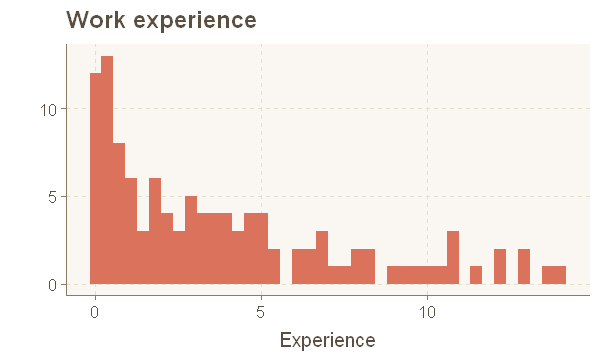

In [21]:
dsml %>% 
    ggplot(aes(x = exp_total)) +
    geom_histogram(bins = 40) +
    labs(title = 'Work experience', x = 'Experience', y = '')

sex,n
<chr>,<int>
Женщина,33
Мужчина,80


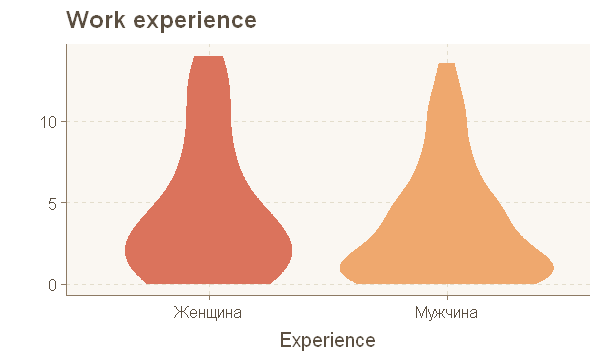

In [22]:
dsml %>% 
    count(sex)

dsml %>% 
    ggplot(aes(x = sex, y = exp_total, fill = sex)) +
    geom_violin(color = NA) +
    #scale_fill_manual(values = sex_colors_dark) +
    labs(title = 'Work experience', x = 'Experience', y = '') +
    theme(legend.position = 'none')

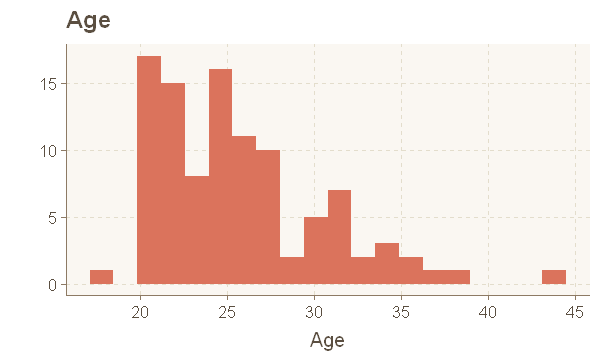

In [23]:
dsml %>% 
    ggplot(aes(x = age)) +
    geom_histogram(bins = 20) +
    labs(title = 'Age', x = 'Age', y = '')

In [24]:
dsml %>% 
    count(city, sort = T) %>% 
    mutate(share = scales::percent(n / nrow(dsml)))

city,n,share
<chr>,<int>,<chr>
Алматы,75,66.4%
Нур-Султан,25,22.1%
Атырау,9,8.0%
Актобе,2,1.8%
Караганда,1,0.9%
Шымкент,1,0.9%


In [25]:
dsml %>% 
    filter(!is.na(experience_companies)) %>% 
    select(id, position, experience_companies) %>% 
    tidyr::separate_rows(experience_companies, sep = '_') %>% 
    mutate(experience_companies = case_when(str_detect(tolower(experience_companies), 'kaspi|каспи') ~ 'Kaspi Bank, АО',
                                            str_detect(tolower(experience_companies), 'назарбаев|nazarbayev') ~ 'NU',
                                            str_detect(tolower(experience_companies), 'beeline|2day|билайн') ~ 'Beeline, ТМ',
                                            str_detect(tolower(experience_companies), 'ess') ~ 'ESS Support Services LLP',
                                            str_detect(tolower(experience_companies), 'home credit|хоум кредит') ~ 'Хоум Кредит Банк, АО',
                                           TRUE ~ experience_companies)) %>% 
    group_by(experience_companies) %>% 
    summarise(cnt = n_distinct(id)) %>% 
    ungroup %>% 
    arrange(-cnt) %>% 
    head(10) %>% 
    mutate(share = scales::percent(cnt / nrow(dsml)))

experience_companies,cnt,share
<chr>,<int>,<chr>
"Kaspi Bank, АО",10,8.85%
"Beeline, ТМ",7,6.19%
NU,6,5.31%
"Хоум Кредит Банк, АО",6,5.31%
ESS Support Services LLP,5,4.42%
KPMG (Казахстан),3,2.65%
"Банк ЦентрКредит, АО",3,2.65%
BTS Digital,2,1.77%
Fircroft Engineering Services Limited,2,1.77%


In [26]:
dsml %>% 
    filter(!is.na(education)) %>% 
    select(id, position, education) %>% 
    tidyr::separate_rows(education, sep = '_') %>% 
    mutate(education = case_when(str_detect(tolower(education), 'демирел|sdu|сду|demirel') ~ 'SDU',
                                 str_detect(tolower(education), 'фараби|farabi|казну') ~ 'КазНУ',
                                 str_detect(tolower(education), 'назарбаев|nazarbayev') ~ 'NU',
                                 str_detect(tolower(education), 'муит|информационных тех|it university|information tech') ~ 'МУИТ',
                                 str_detect(tolower(education), 'ену|евразийский|eurasian|гумил') ~ 'ЕНУ',
                                 str_detect(tolower(education), 'сатпаева|казнту|национальный техн|satpayev|kazntu') ~ 'КазНТУ',
                                 str_detect(tolower(education), 'кбту|британский тех|british tech|kbtu') ~ 'КБТУ',
                                 TRUE ~ education)) %>% 
    group_by(education) %>% 
    summarise(cnt = n_distinct(id)) %>% 
    ungroup %>%
    arrange(-cnt) %>% 
    head(7) %>% 
    mutate(share = scales::percent(cnt / nrow(dsml)))

education,cnt,share
<chr>,<int>,<chr>
SDU,19,16.8%
МУИТ,19,16.8%
NU,12,10.6%
КазНУ,10,8.8%
КБТУ,7,6.2%
КазНТУ,6,5.3%
ЕНУ,5,4.4%


In [27]:
skills_table <- 
    dsml %>% 
    filter(!is.na(skills)) %>% 
    select(id, position, skills) %>% 
    tidyr::separate_rows(skills, sep = '_') %>% 
    group_by(skills) %>% 
    summarise(cnt = n_distinct(id)) %>% 
    arrange(-cnt) %>% 
    filter(cnt > 1)

skills_table %>% 
    head(10) %>% 
    mutate(share = scales::percent(cnt / nrow(dsml)))

skills,cnt,share
<chr>,<int>,<chr>
python,71,62.8%
sql,39,34.5%
data analysis,38,33.6%
machine learning,24,21.2%
java,22,19.5%
ms excel,21,18.6%
mysql,20,17.7%
data mining,19,16.8%
ms office,19,16.8%


In [28]:
skills_table %>% 
    setNames(c('word', 'freq')) %>% 
    wordcloud2(.)

HTML widgets cannot be represented in plain text (need html)